In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
import keras
keras.__version__
!pip install -U scipy==1.2.0

Requirement already up-to-date: scipy==1.2.0 in /usr/local/lib/python3.6/dist-packages (1.2.0)


In [25]:

from keras.preprocessing.image import load_img, img_to_array

# Path for Content Image
content_img_path = '/content/drive/My Drive/d/anthony-fomin-3-H7JpyiWbc-unsplash.jpg'
# Path for style image
style_img_path = '/content/drive/My Drive/d/style_img.jpg'
# Dimenstion of input content image 
width, height = load_img(content_img_path).size
print(width)
print(height)
# Dimensions of the generated picture (defining in a way that h:w ratio remains same)
img_height = 400
img_width = int(width * img_height / height)
print(img_width)
print(img_height)


1920
1280
600
400


In [0]:
import numpy as np
from keras.applications import vgg19

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

# [StackOverflow]
def deprocess_image(x):
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    
    # BGR to RGB <-- as keras reads an image as BGR so it should be converted
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [27]:
from keras import backend as K

content_image = K.constant(preprocess_image(content_img_path))
style_image = K.constant(preprocess_image(style_img_path))

# This placeholder will contain our generated image
# Note Placeholder is a node (same as a variable) whose value can be initialized in the future
combination_image = K.placeholder((1, img_height, img_width, 3))

# We combine the 3 images into a single batch
input_tensor = K.concatenate([content_image,
                              style_image,
                              combination_image], axis=0)

# We build the VGG19 network with our batch of 3 images as input.
# The model will be loaded with pre-trained ImageNet weights.
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [0]:
# Content loss function
def content_loss(base, combination):
    return K.sum(K.square(combination - base))/2

In [0]:
# Style loss function

def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [0]:
# Dict. mapping layer names to activation tensors
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
# Name of layer used for content loss (from paper)
content_layer = 'block4_conv2'
# Name of layers used for style loss (from paper)
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
# Weights in the weighted average of the loss components
# alpha / beta = order 10^-3
style_weight = 10.
content_weight = 0.025

# Total Loss represented by - loss
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(content_image_features, combination_features)

for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(style_layers)) * sl


In [0]:
# [MEDIUM]
# Get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)[0]

# Function to fetch the values of the current loss and the current gradients
fetch_loss_and_grads = K.function([combination_image], [loss, grads])


class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [32]:
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import time

output_name = 'output_img'
iterations = 20

# Using scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss. 
# Note: flattened input only
# format initial state: the target image.

x = preprocess_image(content_img_path)
x = x.flatten()
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x, fprime=evaluator.grads, maxfun=10)
    print('Current loss value:', min_val)
   
    # Saving generated image
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = output_name + '_at_iteration_%d.png' % i
    imsave(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 51117154000.0
Image saved as output_img_at_iteration_0.png
Iteration 0 completed in 2s
Start of iteration 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Current loss value: 24005775000.0
Image saved as output_img_at_iteration_1.png
Iteration 1 completed in 2s
Start of iteration 2
Current loss value: 16445630000.0
Image saved as output_img_at_iteration_2.png
Iteration 2 completed in 2s
Start of iteration 3
Current loss value: 13805506000.0
Image saved as output_img_at_iteration_3.png
Iteration 3 completed in 2s
Start of iteration 4
Current loss value: 12370310000.0
Image saved as output_img_at_iteration_4.png
Iteration 4 completed in 2s
Start of iteration 5
Current loss value: 11277612000.0
Image saved as output_img_at_iteration_5.png
Iteration 5 completed in 2s
Start of iteration 6
Current loss value: 10648785000.0
Image saved as output_img_at_iteration_6.png
Iteration 6 completed in 2s
Start of iteration 7
Current loss value: 10256548000.0
Image saved as output_img_at_iteration_7.png
Iteration 7 completed in 2s
Start of iteration 8
Current loss value: 9753279000.0
Image saved as output_img_at_iteration_8.png
Iteration 8 completed in 2

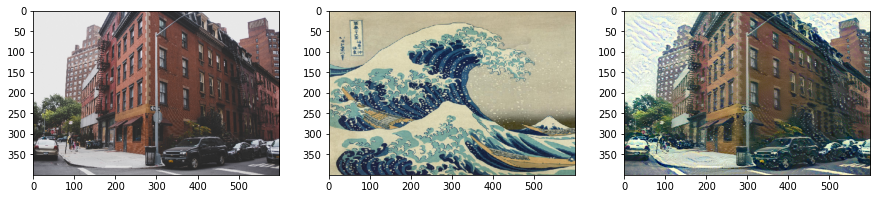

In [33]:
# Plotting images in a row
import matplotlib.pyplot as plt

# Defining size on figure
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)

ax1 = fig.add_subplot(1,3,1)
ax1.imshow(load_img(content_img_path, target_size=(img_height, img_width)))
ax2 = fig.add_subplot(1,3,2)
ax2.imshow(load_img(style_img_path, target_size=(img_height, img_width)))
ax3 = fig.add_subplot(1,3,3)
ax3.imshow(img)